In [1]:
# Modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import sys
sys.path.insert(0,'../')  # add previous directory to path to load constants module
import constants as const

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
print(tf.__version__)

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
import statistics


2024-10-29 10:25:38.029897: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 10:25:38.031952: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-29 10:25:38.058677: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 10:25:38.058704: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 10:25:38.059743: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0


In [2]:
# Import dataset using pandas

raw_dataset = pd.read_csv('../Datasets/dataset_reduced.csv')
dataset = raw_dataset.copy()
print("Shape of dataset: "+str(dataset.shape))
dataset.tail()

Shape of dataset: (602649, 17)


,turbine,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,R80736,16.480000,19.290001,-132.56,15.730000,20.680000,19.170000,19.920000,-137.95,-5.37,7.27,1.801180,29.480000,-137.95,-137.95,10823.5,2043069.9
602645,R80736,16.740000,19.059999,-132.56,15.600000,20.799999,19.299999,20.049999,-138.02,-5.44,7.23,1.798038,29.379999,-138.02,-138.02,10843.5,2043060.1
602646,R80736,17.370001,17.000000,-158.05,16.389999,21.010000,19.920000,20.469999,-156.45,1.60,8.87,1.801180,32.730000,-156.45,-156.45,10853.3,2048070.1
602647,R80711,16.820000,16.000000,-117.44,15.170000,21.120001,19.840000,20.480000,-122.41,-4.99,9.31,1.801180,26.010000,-122.41,-122.41,10817.3,2041980.0
602648,R80736,17.610001,17.000000,-134.75,16.709999,21.280001,19.719999,20.500000,-140.38,-5.62,10.31,1.799085,27.200001,-140.38,-140.38,10837.3,2043120.0


In [3]:
# Clean dataset of NaN values
#dataset.isna().sum()
print(dataset.isna().sum())
dataset = dataset.dropna()

turbine                0
theta                  0
hub_temperature        0
nacelle_angle          0
nacelle_temperature    0
V1                     0
V2                     0
V                      0
Wind_angle             0
Vane_angle             0
Out_temperature        0
W                      0
Rotor_temperature      0
Wind_angle_c           0
nacelle_angle_c        0
T                      0
P                      0
dtype: int64


In [4]:
# One-hot encode categorical columns

dataset['turbine'] = dataset['turbine'].map({1:'R80711', 2:'R80721',3:'R80736', 4:'R80790'})
dataset = pd.get_dummies(dataset, columns=['turbine'], prefix='', prefix_sep='')
dataset.tail()

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P
602644,16.480000,19.290001,-132.56,15.730000,20.680000,19.170000,19.920000,-137.95,-5.37,7.27,1.801180,29.480000,-137.95,-137.95,10823.5,2043069.9
602645,16.740000,19.059999,-132.56,15.600000,20.799999,19.299999,20.049999,-138.02,-5.44,7.23,1.798038,29.379999,-138.02,-138.02,10843.5,2043060.1
602646,17.370001,17.000000,-158.05,16.389999,21.010000,19.920000,20.469999,-156.45,1.60,8.87,1.801180,32.730000,-156.45,-156.45,10853.3,2048070.1
602647,16.820000,16.000000,-117.44,15.170000,21.120001,19.840000,20.480000,-122.41,-4.99,9.31,1.801180,26.010000,-122.41,-122.41,10817.3,2041980.0
602648,17.610001,17.000000,-134.75,16.709999,21.280001,19.719999,20.500000,-140.38,-5.62,10.31,1.799085,27.200001,-140.38,-140.38,10837.3,2043120.0


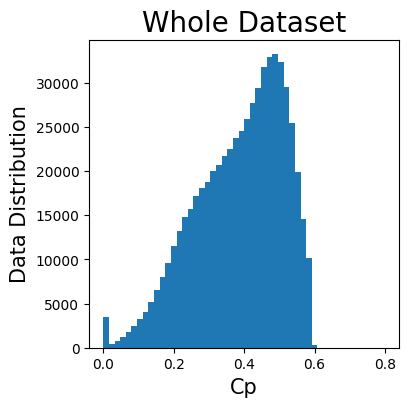

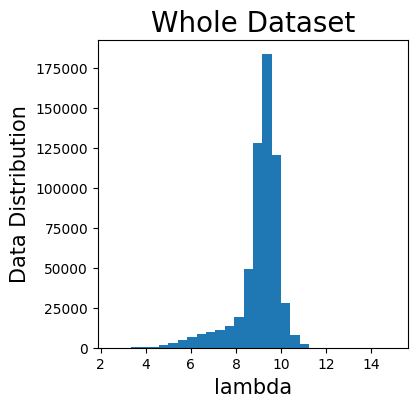

,theta,hub_temperature,nacelle_angle,nacelle_temperature,V1,V2,V,Wind_angle,Vane_angle,Out_temperature,W,Rotor_temperature,Wind_angle_c,nacelle_angle_c,T,P,Cp,lambda
602644,16.480000,19.290001,-132.56,15.730000,20.680000,19.170000,19.920000,-137.95,-5.37,7.27,1.801180,29.480000,-137.95,-137.95,10823.5,2043069.9,0.079908,3.707248
602645,16.740000,19.059999,-132.56,15.600000,20.799999,19.299999,20.049999,-138.02,-5.44,7.23,1.798038,29.379999,-138.02,-138.02,10843.5,2043060.1,0.078364,3.676787
602646,17.370001,17.000000,-158.05,16.389999,21.010000,19.920000,20.469999,-156.45,1.60,8.87,1.801180,32.730000,-156.45,-156.45,10853.3,2048070.1,0.073819,3.607639
602647,16.820000,16.000000,-117.44,15.170000,21.120001,19.840000,20.480000,-122.41,-4.99,9.31,1.801180,26.010000,-122.41,-122.41,10817.3,2041980.0,0.073492,3.605878
602648,17.610001,17.000000,-134.75,16.709999,21.280001,19.719999,20.500000,-140.38,-5.62,10.31,1.799085,27.200001,-140.38,-140.38,10837.3,2043120.0,0.073318,3.598171


In [5]:
# Add Cp and lambda to the dataset

def Cp_fromP(Pturbina, Vw):

    Cp = Pturbina / (0.5 * const.rho * const.A * Vw**3)

    return Cp

def lambd(Vw, Wwt):

    lambd = Wwt * const.R / Vw

    return lambd

Cp_data = Cp_fromP(dataset['P'][:],dataset['V'][:])
dataset['Cp'] = Cp_data
lambd_data = lambd(dataset['V'][:], dataset['W'][:])
dataset['lambda'] = lambd_data

plt.figure(figsize=(4,4))
plt.hist(Cp_data, range=[0.0, 0.8], bins=50)
plt.xlabel('Cp',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

# Histogram of lambda
plt.figure(figsize=(4,4))
plt.hist(lambd_data, range=[2.5, 15], bins=30)
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Data Distribution',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
plt.show()

dataset.tail()

In [6]:
# Split the data into training and test sets

train_dataset = dataset.sample(frac=0.8, random_state=10)
test_dataset = dataset.drop(train_dataset.index)

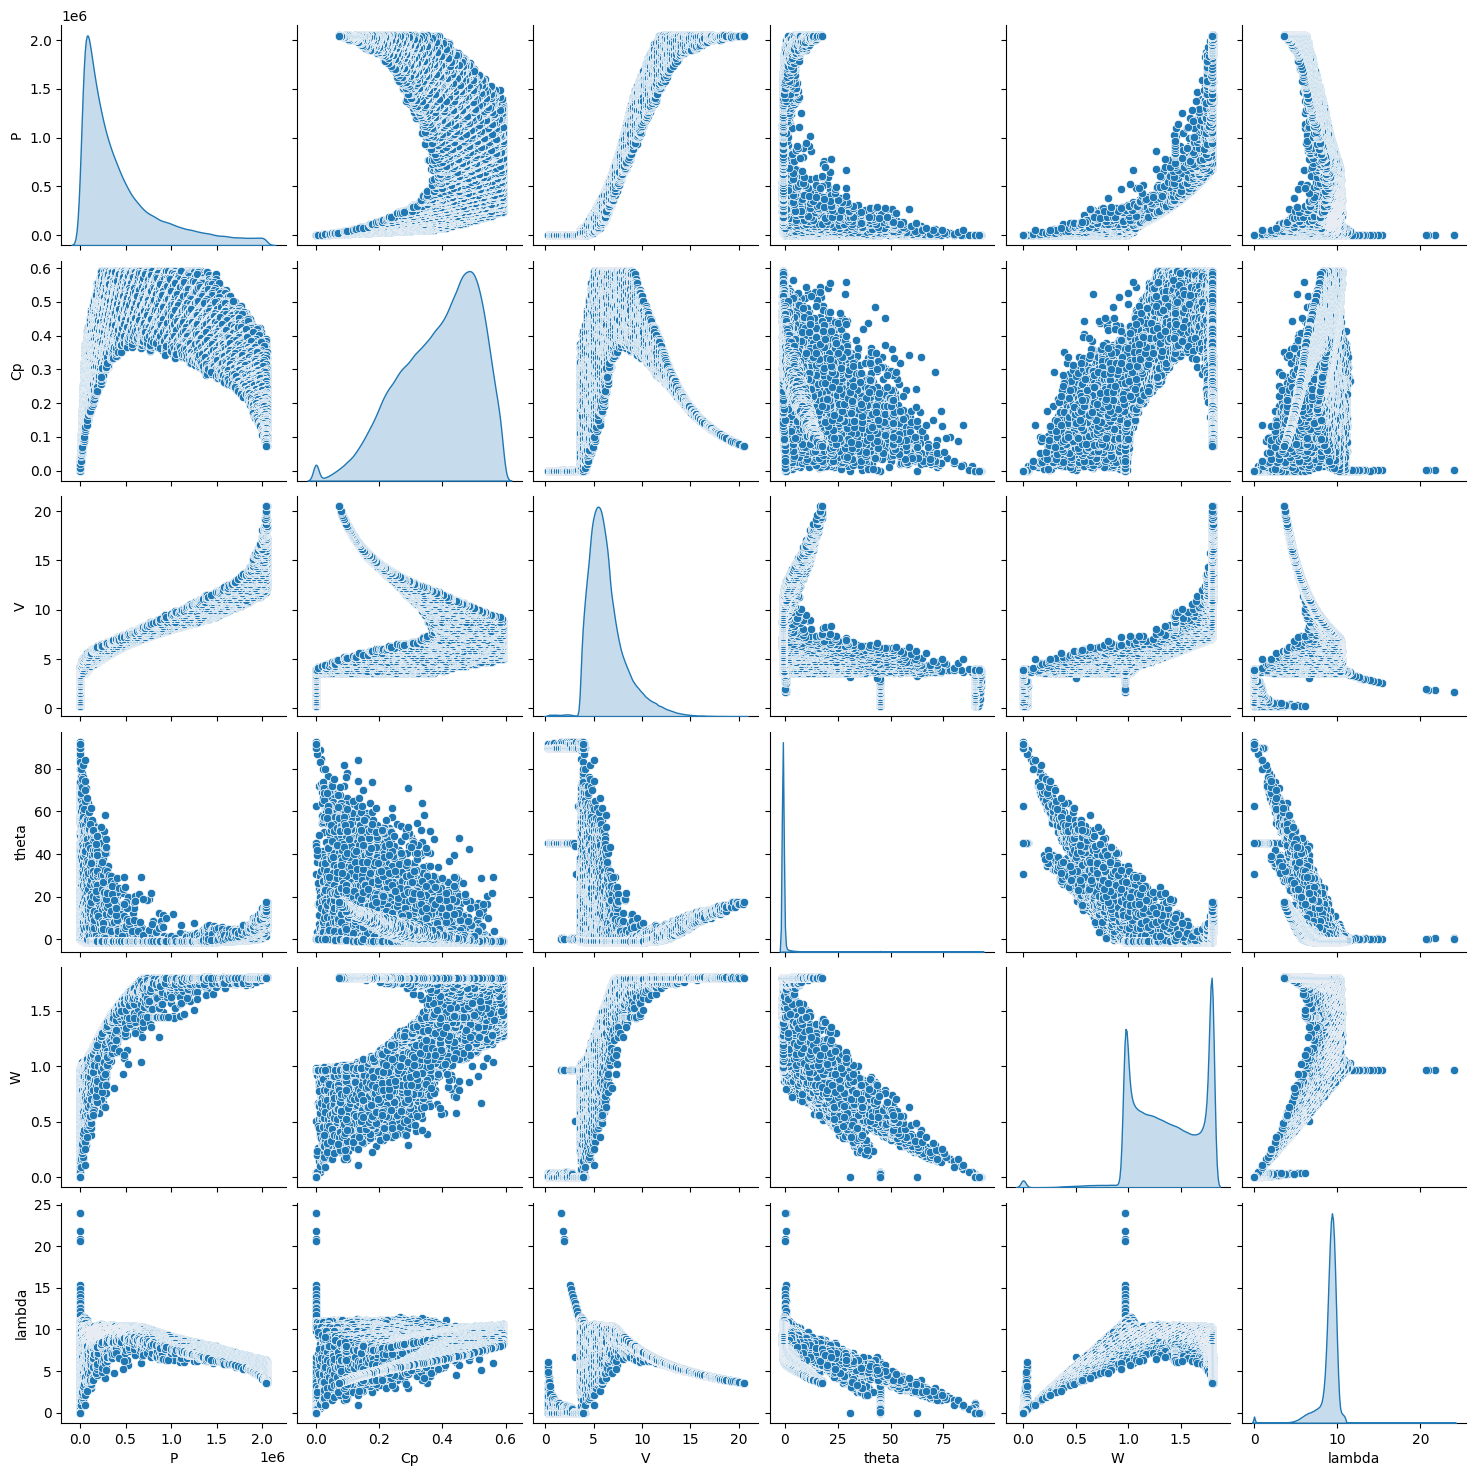

In [7]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

sns.pairplot(dataset[['P', 'Cp', 'V', 'theta', 'W', 'lambda']], diag_kind='kde')

In [7]:
# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
theta,602649.0,-0.081045,5.978549,-1.08,-1.000000,-0.990000,-0.900000,9.276000e+01
hub_temperature,602649.0,19.060174,5.838598,4.05,14.170000,18.719999,23.000000,3.900000e+01
nacelle_angle,602649.0,-28.785794,111.742447,-180.00,-130.160000,-59.269990,55.330002,1.799900e+02
nacelle_temperature,602649.0,24.595032,6.192875,1.49,20.639999,25.110001,28.969999,4.291000e+01
V1,602649.0,6.306669,2.018830,0.00,4.950000,5.870000,7.130000,2.128000e+01
V2,602649.0,6.321526,1.956744,0.00,4.990000,5.900000,7.140000,2.015000e+01
V,602649.0,6.314169,1.982688,0.23,4.970000,5.890000,7.130000,2.050000e+01
Wind_angle,602649.0,-28.404289,112.121101,-180.00,-130.640000,-57.989990,56.000000,1.799900e+02
Vane_angle,602649.0,-0.184985,9.427393,-179.34,-5.310000,-0.460000,4.800000,1.797500e+02
Out_temperature,602649.0,11.473260,7.091906,-6.95,5.960000,10.910000,16.330000,3.828000e+01


In [8]:
# Normalization. 
# Cp in the range [0,1]. Originally, it was in [0,Cp_max]
# Rest of the variables with mean 0 and std 1

print(dataset.describe().transpose()[['mean', 'std']])

x_mean = np.nanmean( dataset, axis=0)
x_std = np.nanstd( dataset, axis=0 )

column_name = dataset.columns.values
Cp_column = column_name[5]
#print(Cp_column)

Cp_max = 0.5926
train_dataset_norm = train_dataset.copy()
test_dataset_norm = test_dataset.copy()
icol = 0
for col in column_name:
    if(col!='Cp'): # mean 0 and std 1
        train_dataset_norm[col]=(train_dataset[col]-x_mean[icol])/x_std[icol]
        test_dataset_norm[col]=(test_dataset[col]-x_mean[icol])/x_std[icol]
    else: # Cp in [0,1]
        train_dataset_norm[col]=train_dataset[col]/Cp_max
        test_dataset_norm[col]=test_dataset[col]/Cp_max
    icol = icol+1

print()
print("Normalized dataset")
print(train_dataset_norm.describe().transpose()[['mean', 'std']])

                              mean            std
theta                    -0.081045       5.978549
hub_temperature          19.060174       5.838598
nacelle_angle           -28.785794     111.742447
nacelle_temperature      24.595032       6.192875
V1                        6.306669       2.018830
V2                        6.321526       1.956744
V                         6.314169       1.982688
Wind_angle              -28.404289     112.121101
Vane_angle               -0.184985       9.427393
Out_temperature          11.473260       7.091906
W                         1.362470       0.318853
Rotor_temperature        28.486577       4.714501
Wind_angle_c            -29.302312     111.841797
nacelle_angle_c         -29.710568     111.627225
T                      2646.532389    2258.267705
P                    444860.879260  446349.165241
Cp                        0.386876       0.124435
lambda                    9.004813       1.167138

Normalized dataset
                         mean 

In [9]:
# Split input features from labels/targets

train_dataset_copy = train_dataset_norm.copy()
test_dataset_copy = test_dataset_norm.copy()

#train_features = train_dataset_copy[['V','theta','W']]
#test_features = test_dataset_copy[['V','theta','W']]
train_features = train_dataset_copy[['lambda','theta']]
test_features = test_dataset_copy[['lambda','theta']]

train_labels = train_dataset_copy.pop('Cp')
test_labels = test_dataset_copy.pop('Cp')

print(train_features.shape)
print(train_labels.shape)

(482119, 2)
(482119,)


In [10]:
# Define the hypermodel to optimize hyperparameters
 
def model_builder(hp):
  
  #input = tf.keras.Input(shape=(3,))
  input = tf.keras.Input(shape=(2,))
  model = keras.Sequential()

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=128, step=2, sampling='log')
  
  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  model.add(input)
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(keras.layers.Dense(units=hp_units, activation=hp_activation))
  # final sigmoid layer to ensure the physical restriction for Cp
  model.add(keras.layers.Dense(1,activation='sigmoid')) 

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                #loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                #metrics=['accuracy'])
                loss='mean_absolute_error')   

  return model

In [11]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(model_builder,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=20,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='Cp2D_sigmoid_constrained')


Reloading Tuner from ./Hypertuning/Cp2D_sigmoid_constrained/tuner0.json


In [12]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

x = train_features  # input features are lambda and theta

# if batch_size is not specified, 32 is the default value
batch_size = 128
tuner.search(x, train_labels, epochs=20, validation_split=0.2, batch_size=batch_size, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: {best_hps.get('layers')}
n_units: {best_hps.get('units')}
learning_rate: {best_hps.get('learning_rate')}
activation_function: {best_hps.get('activation')}
""")

Trial 30 Complete [00h 01m 16s]
val_loss: 0.07471779733896255

Best val_loss So Far: 0.07471779733896255
Total elapsed time: 00h 11m 07s

The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: 2
n_units: 128
learning_rate: 0.001
activation_function: relu



In [13]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)

# Build the model with the optimal hyperparameters and train it on the data for 500 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x, train_labels, epochs=150, batch_size=batch_size, validation_split=0.2, callbacks=[reduce_lr])


Epoch 1/150
3014/3014 [==============================] - 3s 803us/step - loss: 0.0837 - val_loss: 0.0776 - lr: 0.0010
Epoch 2/150
3014/3014 [==============================] - 2s 780us/step - loss: 0.0773 - val_loss: 0.0767 - lr: 0.0010
Epoch 3/150
3014/3014 [==============================] - 2s 776us/step - loss: 0.0768 - val_loss: 0.0762 - lr: 0.0010
Epoch 4/150
3014/3014 [==============================] - 2s 761us/step - loss: 0.0763 - val_loss: 0.0764 - lr: 0.0010
Epoch 5/150
3014/3014 [==============================] - 2s 775us/step - loss: 0.0760 - val_loss: 0.0764 - lr: 0.0010
Epoch 6/150
3014/3014 [==============================] - 3s 907us/step - loss: 0.0757 - val_loss: 0.0755 - lr: 0.0010
Epoch 7/150
3014/3014 [==============================] - 3s 975us/step - loss: 0.0756 - val_loss: 0.0750 - lr: 0.0010
Epoch 8/150
3014/3014 [==============================] - 3s 968us/step - loss: 0.0755 - val_loss: 0.0755 - lr: 0.0010
Epoch 9/150
3014/3014 [==============================] -

Best epoch: 94


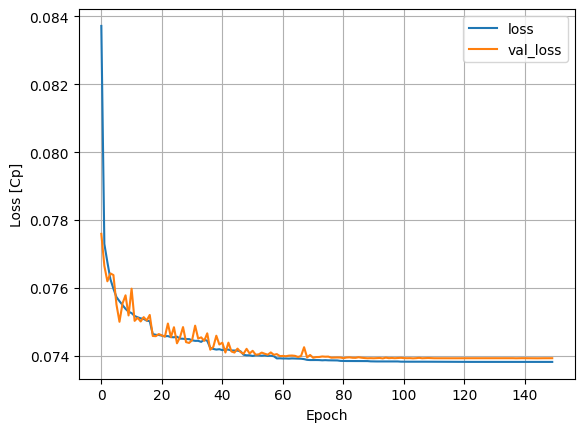

In [14]:
# Plot the loss
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss [Cp]')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
""" # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(x, train_labels, epochs=best_epoch, batch_size=128, validation_split=0.2, callbacks=[reduce_lr]) """

In [15]:
# save model weights 
#model.save_weights('../Models/Cp_model_weights.hdf5')

# load model weights
#model.load_weights('../Models/Cp_model_weights.hdf5')

# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('../Models/Cp2D_sigmoid.h5')

# Recreate the exact same model, including its weights and the optimizer
#new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
#new_model.summary()

/home/alfonso/Work/UGR/Calculations/WindTurbines_hybrid/WT_hybrid_venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [118]:
# load model 

model = tf.keras.models.load_model('../Models/Cp2D_sigmoid.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               384       
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 17025 (66.50 KB)
Trainable params: 17025 (66.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


3767/3767 [==============================] - 2s 411us/step


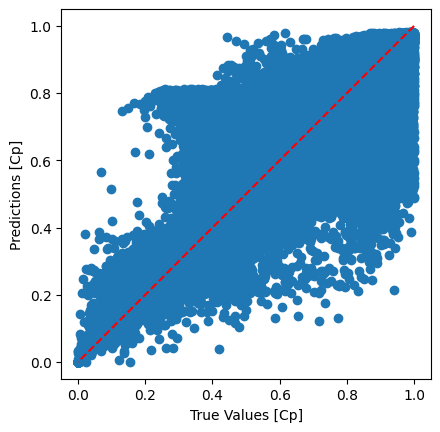

Test MAE: 0.07431886345148087


In [119]:
# Evaluate the model on Cp data

# Pred vs True values

#test_pred = model.predict(test_features[['V','theta','W']]).flatten()
test_pred = model.predict(test_features[['lambda', 'theta']]).flatten()

a = plt.axes(aspect='equal')
p1 = max(max(test_pred), max(test_labels))
p2 = min(min(test_pred), min(test_labels))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(test_labels, test_pred)
plt.xlabel('True Values [Cp]')
plt.ylabel('Predictions [Cp]')
plt.show()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

#test_result = model.evaluate(test_features[['V','theta','W']], test_labels, verbose=0)
test_result = model.evaluate(test_features[['lambda','theta']], test_labels, verbose=0)
print("Test MAE: "+str(test_result))

18833/18833 [==============================] - 8s 414us/step
(602649, 1)
0.37943384
(602649,)
0.38687603243748964


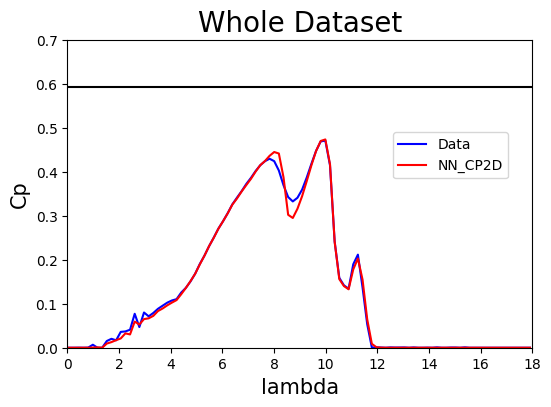

In [120]:
# Plot Cp vs lambda, averaging theta

# Prediction of Cp
x_norm = np.zeros((len(dataset['lambda']),2))
#x_V = (dataset['V'] - dataset['V'].mean()) / dataset['V'].std()
#x_W = (dataset['W'] - dataset['W'].mean()) / dataset['W'].std()
x_lambda = (dataset['lambda'] - dataset['lambda'].mean()) / dataset['lambda'].std()
x_theta = (dataset['theta'] - dataset['theta'].mean()) / dataset['theta'].std()

#x_norm[:,0] = x_V[:]
#x_norm[:,2] = x_W[:]
x_norm[:,0] = x_lambda[:]
x_norm[:,1] = x_theta[:]
Cp_norm = model.predict(x_norm)
#Cp_pred = Cp_norm * dataset['Cp'].std() + dataset['Cp'].mean()
Cp_pred = Cp_norm * Cp_max

# Estimate the Cp curve with the median
lmin = 0
lmax = 18
nbins = 100
Cp_estimated = np.zeros(nbins)
Cp_estimated_NN = np.zeros(nbins)
lambd_estimated = np.zeros(nbins)
dl = (lmax-lmin)/nbins

print(Cp_pred.shape)
print(np.mean(Cp_pred))
print(Cp_data.shape)
print(np.mean(Cp_data))

#Cp_predicted = np.zeros(nbins)

for i in range(1,nbins):
    lambdal = lmin + i*dl
    lambdar = lambdal + dl

    # Median of Cp in the bin i
    lambd_estimated[i] = (lambdal+lambdar)/2.0
    l_subset = (lambdal<lambd_data) & (lambd_data<lambdar)  # subset of lambda points of the bin
    Cpi = Cp_data[l_subset]     # Cp distribution of bin i
    Cpi_NN = Cp_pred[l_subset,0]  # Cp distribution of bin i
    if (len(Cpi)>0):
        Cp_estimated[i]=statistics.mean(Cpi)
        Cp_estimated_NN[i]=statistics.mean(Cpi_NN)

# Plot Cp vs lambda of all data
Cp_max = 0.5926
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
plt.title('Whole Dataset',fontsize=20)
#plt.scatter(lambd_data, Cp_data,facecolors='none',edgecolors='blue')
#plt.scatter(lambd_data,Cp_predicted, facecolors='none',edgecolors='green')
plt.plot(lambd_estimated, Cp_estimated, 'b-',label='Data')
plt.plot(lambd_estimated, Cp_estimated_NN, 'r-',label='NN_CP2D')
#plt.plot(lambd_data, Cp_predicted, 'go')
#plt.plot(lambd_predicted,Cp_data,'bo')
plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
plt.xlim([0,18])
plt.ylim([0,0.7])
l1 = plt.legend(bbox_to_anchor=(0.7, 0.7), borderaxespad=0)
plt.show()

In [121]:
theta_data = dataset['theta'][:]#.to_numpy()

# Calculate statistics
mean = np.mean(theta_data)
min_value = np.min(theta_data)
max_value = np.max(theta_data)
Q1 = np.percentile(theta_data, 25)   # 1st quartile (25th percentile)
Q2 = np.percentile(theta_data, 50)   # 2nd quartile (median, 50th percentile)
Q3 = np.percentile(theta_data, 75) 
P95 = np.percentile(theta_data, 95) 

print(mean)
print(min_value)
print(max_value)
print(Q1)
print(Q2)
print(Q3)
print(P95)

-0.08104465873839863
-1.0800000000000125
92.760002
-1.0
-0.9900000099999884
-0.8999999799999898
0.8500000200000102


In [122]:
print(Cp_data.shape)
print(Cp_pred.shape)

(602649,)
(602649, 1)


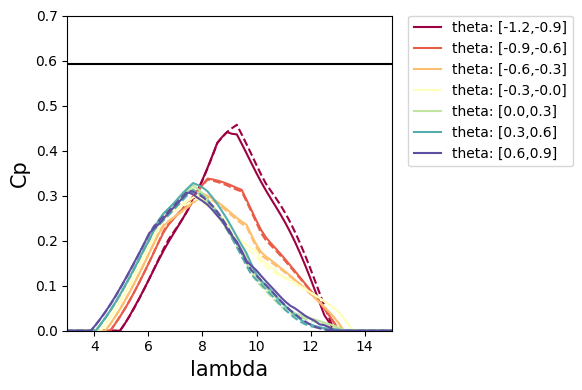

In [125]:
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy.interpolate import make_interp_spline

def moving_average(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

# Estimate the Cp curve with the median

# lambda binning
lmin = 0
lmax = 18
nbins = 100
Cp_estimated = np.zeros(nbins)
Cp_estimated_NN = np.zeros(nbins)
lambd_estimated = np.zeros(nbins)
dl = (lmax-lmin)/nbins

# theta bining
theta_min = -1.2  # (degrees)
theta_max = 0.9  
nangles = 7
da = (theta_max - theta_min) / nangles

# Generate a colormap with one color per angle bin
#colors = cm.viridis(np.linspace(0, 1, nangles))
colors = cm.Spectral(np.linspace(0, 1, nangles))

# Plot setup
plt.figure(figsize=(6,4))
plt.xlabel('lambda',fontsize=15)
plt.ylabel('Cp',fontsize=15)
#plt.title('Whole Dataset',fontsize=20)
Cp_max = 0.5926

for j in range(nangles):
    angle_l = theta_min + j*da
    angle_h = angle_l + da
    angle = (angle_l + angle_h)/2

    cond_angle = (angle_l<theta_data) & (theta_data<angle_h)
    theta_prov = theta_data[ cond_angle ]
    lambd_prov = lambd_data[ cond_angle ]
    Cp_prov = Cp_data[ cond_angle ]
    Cp_pred_prov = Cp_pred[ cond_angle,0]

    # Reset the estimated Cp arrays for each angle
    Cp_estimated.fill(0)
    Cp_estimated_NN.fill(0)

    for i in range(1,nbins):
        lambdal = lmin + i*dl
        lambdar = lambdal + dl

        # Median of Cp in the bin i
        lambd_estimated[i] = (lambdal+lambdar)/2.0
        l_subset = (lambdal<lambd_prov) & (lambd_prov<lambdar)  # subset of lambda points of the bin
        Cpi = Cp_prov[l_subset]     # Cp distribution of bin i
        Cpi_NN = Cp_pred_prov[l_subset]  # Cp distribution of bin i
        if (len(Cpi)>0):
            Cp_estimated[i]=statistics.mean(Cpi)
            Cp_estimated_NN[i]=statistics.mean(Cpi_NN)

    # Plot Cp vs lambda of for each angle
    #plt.plot(lambd_estimated, Cp_estimated, label='Data'+str( round(angle_l,2) )+','+str( round(angle_h,2) )+']')
    #plt.plot(lambd_estimated, Cp_estimated_NN, label='NN_CP2D'+str( round(angle_l,2) )+','+str( round(angle_h,2) )+']')

    # Plot Cp_estimated and Cp_estimated_NN with the same color for each angle bin
    """ plt.plot(lambd_estimated, Cp_estimated, color=colors[j],
             label=f'theta: [{round(angle_l, 2)},{round(angle_h, 2)}]')
    plt.plot(lambd_estimated, Cp_estimated_NN, color=colors[j], linestyle='--')#,
             #label=f'NN_CP2D [{round(angle_l, 2)},{round(angle_h, 2)}]') """

    # Apply moving average strategy
    Cp_estimated_smooth = moving_average(Cp_estimated, window_size=20)
    Cp_estimated_NN_smooth = moving_average(Cp_estimated_NN, window_size=20)
    # Apply Savitzky-Golay filter
    #Cp_estimated_smooth = savgol_filter(Cp_estimated, window_length=5, polyorder=2)
    #Cp_estimated_NN_smooth = savgol_filter(Cp_estimated_NN, window_length=5, polyorder=2)

    plt.plot(lambd_estimated, Cp_estimated_smooth, color=colors[j],
             label=f'theta: [{round(angle_l, 2)},{round(angle_h, 2)}]')
    plt.plot(lambd_estimated, Cp_estimated_NN_smooth, color=colors[j], linestyle='--')

plt.axhline(y=Cp_max, color = 'k', linestyle = '-')
plt.xlim([3,15])
plt.ylim([0,0.7])
#l1 = plt.legend(bbox_to_anchor=(0.7, 0.7), borderaxespad=0)
# Add a legend and show the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()
plt.show()

3767/3767 [==============================] - 2s 424us/step


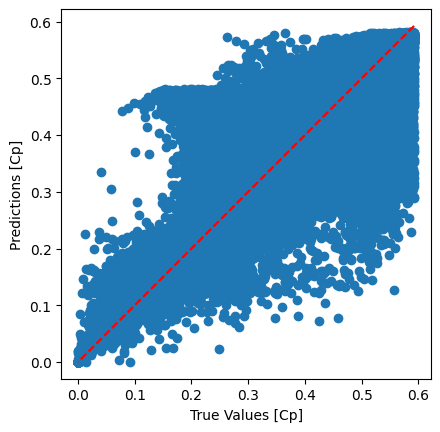


Test MAE: 0.04404134910039965
Test RMSE: 0.06820756440815506
Test MAPE: 13.040932089854145 %
Test R2: 0.698969325159329


In [124]:
# Evaluate Cp on original units

# Pred vs True values

#y_pred = model.predict(test_features[['V','theta','W']]).flatten()
y_pred = model.predict(test_features[['lambda','theta']]).flatten()
y_true = test_labels

y_pred = y_pred * Cp_max
y_true = y_true * Cp_max

a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(y_true, y_pred)
plt.xlabel('True Values [Cp]')
plt.ylabel('Predictions [Cp]')
plt.show()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

y_pred_nonzero = y_pred[abs(y_true)>0]
y_true_nonzero = y_true[abs(y_true)>0]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

3767/3767 [==============================] - 2s 423us/step


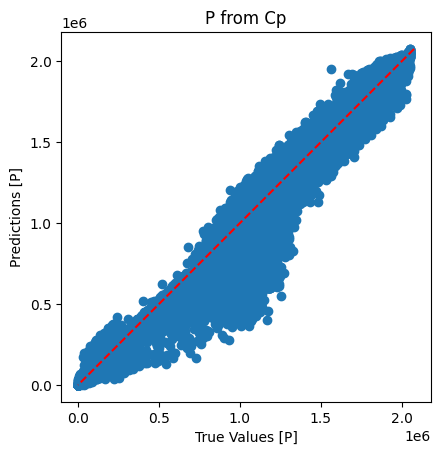


Test MAE: 47284.25785193892
Test RMSE: 96390.54621490109
Test MAPE: 12.16857597447628 %
Test R2: 0.9537152812878549


In [114]:
# Evaluate Data P from Cp

def P_fromCp(Cp, Vw):
    Pturbina = 0.5 * Cp * const.rho * const.A * Vw**3
    return Pturbina

#Cp_pred = model.predict(test_features[['V','theta','W']]).flatten()
Cp_pred = model.predict(test_features[['lambda','theta']]).flatten()
Cp_true = test_labels
Cp_pred = Cp_pred * Cp_max
Cp_true = Cp_true * Cp_max

V_true = test_dataset.loc[:,'V']
V_true = V_true.to_numpy()
P_true = test_dataset.loc[:,'P']
P_true = P_true.to_numpy()
P_pred = P_fromCp(Cp_pred,V_true)

y_true = P_true
y_pred = P_pred

# Plot
a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(y_true, y_pred)
plt.xlabel('True Values [P]')
plt.ylabel('Predictions [P]')
plt.title('P from Cp')
plt.show()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

# Metrics
p_cutoff = 25000
y_pred_nonzero = y_pred[abs(y_true)>p_cutoff]
y_true_nonzero = y_true[abs(y_true)>p_cutoff]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))

3767/3767 [==============================] - 2s 425us/step


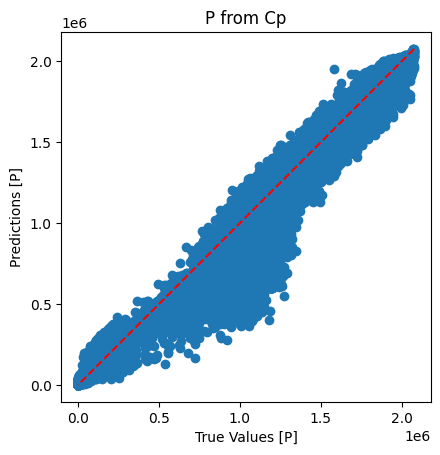


Test MAE: 47508.37009731782
Test RMSE: 97812.51199822294
Test MAPE: 11.911245990859422 %
Test R2: 0.9534359907473947


In [115]:
# Evaluate Physical P (g*T*W) from Cp

def P_fromCp(Cp, Vw):
    Pturbina = 0.5 * Cp * const.rho * const.A * Vw**3
    return Pturbina

def P_fromT(T, W):
    Pturbina = const.gear * T * W
    return Pturbina

#Cp_pred = model.predict(test_features[['V','theta','W']]).flatten()
Cp_pred = model.predict(test_features[['lambda','theta']]).flatten()
Cp_true = test_labels
Cp_pred = Cp_pred * Cp_max
Cp_true = Cp_true * Cp_max

V_true = test_dataset.loc[:,'V']
V_true = V_true.to_numpy()
W_true = test_dataset.loc[:,'W']
W_true = W_true.to_numpy()
T_true = test_dataset.loc[:,'T']
T_true = T_true.to_numpy()
#P_true = test_dataset.loc[:,'P']
#P_true = P_true.to_numpy()
P_true = P_fromT(T_true,W_true)
P_pred = P_fromCp(Cp_pred,V_true)

y_true = P_true
y_pred = P_pred

# Plot
a = plt.axes(aspect='equal')
p1 = max(max(y_pred), max(y_true))
p2 = min(min(y_pred), min(y_true))
plt.plot([p1, p2], [p1, p2], 'r--')
plt.scatter(y_true, y_pred)
plt.xlabel('True Values [P]')
plt.ylabel('Predictions [P]')
plt.title('P from Cp')
plt.show()
#lims = [0, 50]
#plt.xlim(lims)
#plt.ylim(lims)
#_ = plt.plot(lims, lims)

# Metrics
p_cutoff = 25000
y_pred_nonzero = y_pred[abs(y_true)>p_cutoff]
y_true_nonzero = y_true[abs(y_true)>p_cutoff]

test_mae = mean_absolute_error(y_true,y_pred)
test_rmse = mean_squared_error(y_true,y_pred,squared=False)
#test_mape = mean_absolute_percentage_error(y_true,y_pred)*100
test_mape = mean_absolute_percentage_error(y_true_nonzero,y_pred_nonzero)*100
test_r2 = r2_score(y_true,y_pred)

print()
print("Test MAE: "+str(test_mae))
print("Test RMSE: "+str(test_rmse))
print("Test MAPE: "+str(test_mape)+" %")
print("Test R2: "+str(test_r2))